#### Necessary Imports

In [137]:
from collections import namedtuple
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .master("local[*]") \
        .appName("RedditStreamAnalysis") \
        .getOrCreate()
sc = spark.sparkContext
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql import *

from os import listdir
from os.path import isfile, join
import re
import numpy as np
from itertools import chain
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from IPython.display import display, HTML, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
import time
from threading import Thread
from queue import Queue
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

sid = SentimentIntensityAnalyzer()
%matplotlib notebook

#### Post Schema

In [5]:
def postSchema():
    postSchema = StructType()\
            .add("author","string")\
            .add("body", "string")\
            .add("score", "integer")\
            .add("subreddit", "string")\
            .add("edited", "boolean")\
            .add("ups","integer")\
            .add("controversiality", "integer")\
            .add("created_utc", "timestamp")\
            .add("parent_id", "string")\
            .add("subreddit_id", "string")\
            .add("id", "string")
    return postSchema


#### User defined functions
udf vectorizes a function to be used on a dataframe/dataset

In [6]:
def sentimentAnalysisUDF(msg):
    finalScore = 0
    words = tokenize.sent_tokenize(msg)
    for word in words:
        ss = sid.polarity_scores(word)
        wordScore = ss['compound']
        finalScore += wordScore
    msgLen = len(words)
    if msgLen == 0:
        msgLen = 1
    roundedFinalScore = finalScore/msgLen
    return roundedFinalScore

def fixEncodingUDF(msg):
    fixedStr = re.sub(r"[\\xc2-\\xf4][\\x80-\\xbf]+",
                      lambda match: match.group(0).encode('iso-8859-1').decode('utf8'), msg)
    return fixedStr

def flattenStringUDF(msg):
    return msg.lower().split(" ")

def checkInListUDF(obj, lst):
    return obj in lst;

sentimentAnalysis = udf(sentimentAnalysisUDF, returnType=FloatType())
fixEncoding = udf(fixEncodingUDF, returnType=StringType())
flattenString = udf(flattenStringUDF, returnType=ArrayType(StringType()))
checkInList = udf(checkInListUDF, returnType=BooleanType())

In [190]:
class DataframeClass():
    def __init__(self, schema):
        self.dataframe = sqlContext.createDataFrame(sc.emptyRDD(), schema)

class HistogramDataClass():

    def __init__(self):

        self.Width = [0]
        
class XYPlotDataClass():

    def __init__(self):

        self.XData = [0]
        self.YData = [0]
        
class TimeSeriesPlotDataClass():

    def __init__(self):

        self.XData = np.array([], dtype='datetime64[ns]')
        self.YData = np.array([], dtype='float')

In [222]:
class PlotBarhClass():

    def __init__(self, dataClass):

        self._dataClass = dataClass
        plt.figure()
        self.barh = list(plt.barh(0, 0))

        self.ani = FuncAnimation(plt.gcf(), self.run, interval = 1000, repeat=True, blit=True)
        
    def setLabels(self, xlabel, ylabel):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    def run(self, i):
        for b,w in zip(self.barh, self._dataClass):
            b.set_width(w)
            b.axes.relim()
            b.axes.autoscale_view()
            
        
    def getAni(self):
        return self.ani

    
class PlotXYClass():

    def __init__(self, dataClass):

        self._dataClass = dataClass
        plt.figure()
        self.hLine, = plt.plot(self._dataClass.XData, self._dataClass.YData)

        self.ani = FuncAnimation(plt.gcf(), self.run, interval = 1000, repeat=True)


    def run(self, i):  
#         self._dataClass.XData.sort()
#         self._dataClass.YData.sort()
        self.hLine.set_data(self._dataClass.XData, self._dataClass.YData)
        self.hLine.axes.relim()
        self.hLine.axes.autoscale_view()
    
    def setLabels(self, xlabel, ylabel):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    def reset(self):
        self._dataClass.XData = np.array([], dtype='datetime64[ns]')
        self._dataClass.YData = np.array([], dtype='float')
    
    def getAni(self):
        return self.ani

In [224]:
class FetchSentimentAnalysisClass(Thread):

    def __init__(self, dataframe, dataClass, sleepTime, queue, keywords):

        Thread.__init__(self)
        self._dataframe = dataframe
        self._dataClass = dataClass
        self._time = sleepTime
        self._queue = queue
        self._windowTime = "{0} minutes".format(self._time)
        self._keywords = [keyword.lower() for keyword in keywords]
        
        
    def findPostsByKeyword(self):
        schema = StructType([StructField("word", StringType(), True)])
        rdd = sc.parallelize(self._keywords).map(lambda x: Row(x))
        kwDF = sqlContext.createDataFrame(rdd, schema)
        wordsDf = self._dataframe.dataframe.withColumn('word', explode(flattenString('body')))\
                    .select("id", "word")
        wordsFiltered = wordsDf.join(kwDF, 'word', 'inner')\
                    .groupBy("id", "word")\
                    .count()
        postContainingKeywords = self._dataframe.dataframe.join(wordsFiltered, "id", 'inner')\
                                   .sort(desc("count"))
        return postContainingKeywords.select(*list(set(postContainingKeywords.columns) - {"word"})).distinct()

    
    def run(self):
        print('comecou')
        while True:
            if not self._queue.empty() and self._queue.get():           
                print('terminou')
                return
            try:
                # add data to data class
                if len(self._keywords) > 0:
                    kw = self.findPostsByKeyword()
                else:
                    kw = self._dataframe.dataframe
                sa = kw\
                        .select("created_utc", "author", "id", "subreddit", round(sentimentAnalysis("body"),4)\
                        .alias("sentiment_score")).distinct()
                saAvg = sa\
                            .groupBy(window("created_utc", "5 minutes", "1 minute"),"subreddit")\
                            .avg().sort("window")
                saAvgWindowStart = saAvg.select(saAvg.window.start.alias("start"), "avg(sentiment_score)")\
                                    .sort(asc("start"))
                saAvgFinal = saAvgWindowStart.groupBy("start")\
                                .agg(avg("avg(sentiment_score)").alias("avg_sentiment"))\
                                .sort("start")
                saAvgDF = saAvgFinal.toPandas()
                
#                 self._dataClass.XData = np.append(self._dataClass.XData, saAvgDF['start'].values)
#                 self._dataClass.YData = np.append(self._dataClass.YData, saAvgDF['avg_sentiment']\
#                                                   .values)
                self._dataClass.XData = saAvgDF['start'].values
                self._dataClass.YData = saAvgDF['avg_sentiment'].values

                time.sleep(self._time)
            except:
                self._queue.put(True)
                print('exception')
        
        print('terminou')
        
        
class FetchStreamClass(Thread):
    def __init__(self, dataframe, path, queue, sleepTime):

        Thread.__init__(self)
        self._dataframe = dataframe
        self._path = path
        self._time = sleepTime
        self._queue = queue
        self._files = [join(self._path,f) for f in listdir(self._path) if (isfile(join(self._path, f))\
                                                                         and f.split('.')[-1] == "parquet")]
     
    def run(self):
        print("start updating dataframe")
        i = 0
        while True:
            try:
                if not self._queue.empty() and self._queue.get():           
                    print('stop updating dataframe')
                    return
                if i < len(self._files) and len(self._files) > 0:
                    
                    newDataframe = sqlContext.read.parquet(self._files[i]).dropna()
                    self._dataframe.dataframe = self._dataframe.dataframe.union(newDataframe)
                    i += 1
                    
#                 listFiles = [join(self._path,f) for f in listdir(self._path) if (isfile(join(self._path, f))\
#                                                                          and f.split('.')[-1] == "parquet")]
#                 newFiles = list(set(listFiles) - set(self._files))
#                 if len(newFiles) > 0:
#                     newDataframe = sqlContext.read.parquet(*newFiles).dropna()
#                     self._dataframe.dataframe = self._dataframe.dataframe.union(newDataframe)
#                     self._files = listFiles.copy()
                    
                time.sleep(self._time)
            except:
                self._queue.put(True)
                print('exception')

<IPython.core.display.Javascript object>


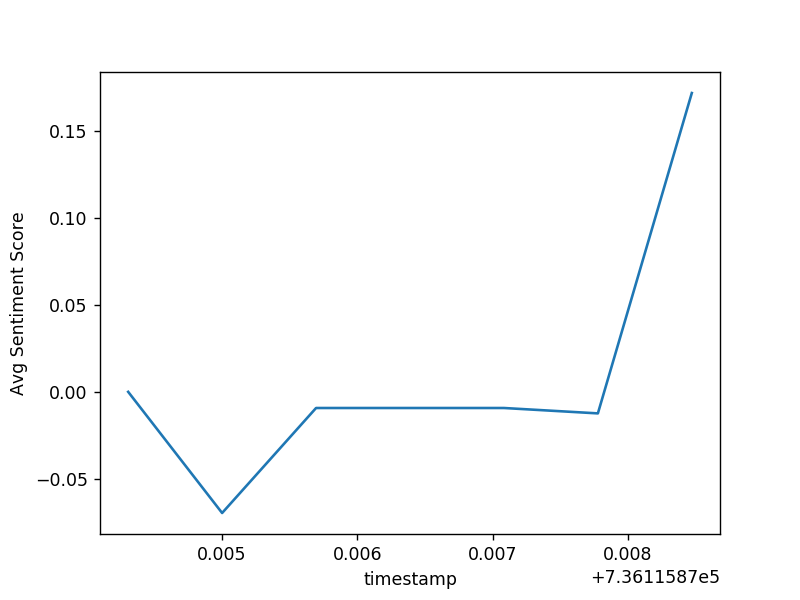

In [227]:
dataframe = DataframeClass(postSchema())
dataframeThread = None
streamQueue, sentimentQueue = Queue(), Queue()
path = "/run/media/gabriel/LinuxExtra/trabalho-spark/spark_reddit/posts_parquet/"
startButton = None
streamSleepTime = 10
sentimentSleepTime = 5
keywords = []
keywordsWidget = None

dataframeThread = None
dataSA = TimeSeriesPlotDataClass()
plotterSA = PlotXYClass(dataSA)
plotterSA.setLabels("timestamp", "Avg Sentiment Score")
fetcherSA = None

def stopPlotButton(b):
    global sentimentQueue, fetcherSA, plotterSA
    sentimentQueue.put(True)
    if(fetcherSA is not None):
        fetcherSA.join()
        plotterSA.getAni().event_source.stop()
        plotterSA.reset()

def startPlotButton(b):
    global sentimentQueue, sentimentSleepTime, keywords, fetcherSA, dataframe, dataSA, plotterSA
    plotterSA.reset()
    fetcherSA = FetchSentimentAnalysisClass(dataframe, dataSA, sentimentSleepTime, sentimentQueue, keywords)
    fetcherSA.start()
    plt.show()

def stopReadStreamButton(b):
    global streamQueue, dataframeThread
    streamQueue.put(True)
    if(dataframeThread is not None):
        dataframeThread.join()
        
def startReadStreamButton(b):
    global dataframeThread, streamQueue, path, dataframe, streamSleepTime
    dataframeThread = FetchStreamClass(dataframe, path, streamQueue, streamSleepTime)
    dataframeThread.start()
    
def updateKeywords(e):
    global keywords, keywordsWidget
    keywords = keywordsWidget.value.split(';')

In [229]:
global keywords

startStream = widgets.Button(description='Start reading Stream')
startStream.on_click(startReadStreamButton)
stopStream = widgets.Button(description='Stop reading Stream')
stopStream.on_click(stopReadStreamButton)
hboxStream = widgets.HBox([stopStream, startStream])

stopPlot = widgets.Button(description="Stop Plot")
stopPlot.on_click(stopPlotButton)
startPlot = widgets.Button(description="Start Plot")
startPlot.on_click(startPlotButton)
keywordsWidget = widgets.Text(placeholder='keywords separated by semicolon')
keywordsWidget.observe(updateKeywords)
hboxPlot = widgets.HBox([stopPlot, startPlot])
vbox = widgets.VBox([hboxStream, keywordsWidget, hboxPlot],
                         layout={'align_items': 'center',
                                 'align_content': 'flex-start',
                                 'justify_content': 'space-around'})
display(vbox)

<IPython.core.display.Javascript object>


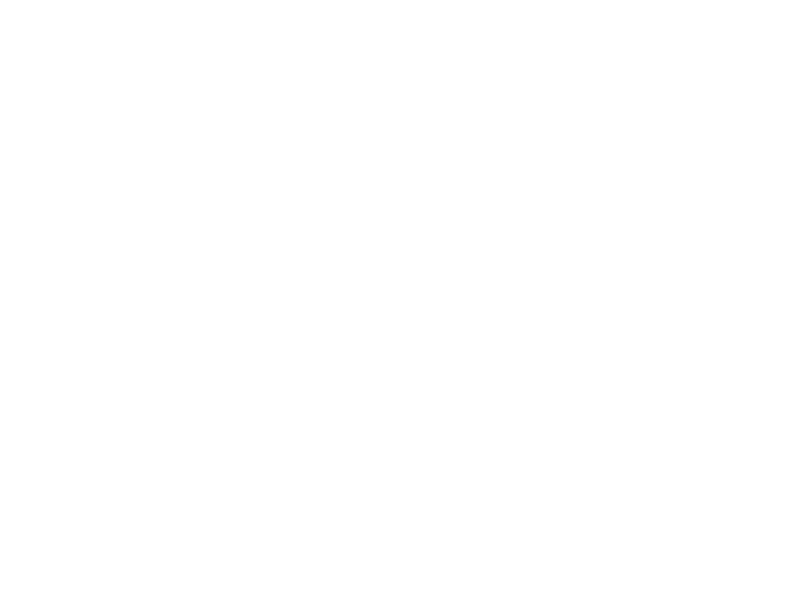

Button(description='Refresh/Show', style=ButtonStyle())

In [230]:
def showMostActiveSubreddits(e):
    global dataframe, outSubs
    outSubs.clear_output()
    subsCounter = dataframe.dataframe.groupBy("subreddit").count().sort(desc("count"))
    subsCounterDF = subsCounter.toPandas()
    r = subsCounterDF[:10]
    plt.barh(r['subreddit'], r['count'], color='lightgreen');
    plt.xlabel("number of posts")
    plt.tight_layout()
    with outSubs:
        plt.show()
    
outSubs = widgets.Output()    
plt.figure()
activeSubredditsButton = widgets.Button(description='Refresh/Show')
activeSubredditsButton.on_click(showMostActiveSubreddits)
display(activeSubredditsButton)

In [193]:
def findActiveUsersInSubreddit(e):
    global dataframe, subredditsDrop, outUsers, activeUsers
    outUsers.clear_output()
    activeUsers = dataframe.dataframe.filter(dataframe.dataframe.subreddit == subredditsDrop.value)\
                    .groupBy("author", "subreddit")\
                    .agg(count("author").alias("num_posts")).sort(desc("num_posts"))
    activeUsersDF = activeUsers.toPandas()
    
    with outUsers:
        display(activeUsersDF)
            
def updateSubredditList(e):
    global dataframe
    subs = dataframe.dataframe.select("subreddit").distinct()
    e.options = np.append(np.array(['None']), subs.toPandas()['subreddit'].values)
    
    
outUsers = widgets.Output()
subredditsDrop = widgets.widgets.Dropdown(
                    options=[],
                    description='Subreddits:',
                    disabled=False)
subredditsDrop.on_displayed(updateSubredditList)
subredditSelected = subredditsDrop.value
activeUsersInSubredditButton = widgets.Button(description='Refresh/Show')
activeUsersInSubredditButton.on_click(findActiveUsersInSubreddit)

hboxSub = widgets.HBox([subredditsDrop, activeUsersInSubredditButton])
display(hboxSub, outUsers)

Output()